In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import display
%matplotlib inline

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 100)
df = pd.read_csv("C:\\Users\\Богдан\\Downloads\\reviews.csv")
df.head()

,listing_id,date
0,109,2011-08-15
1,109,2016-05-15
2,344,2016-06-14
3,344,2016-12-30
4,344,2018-08-28


Посмотрим на наши данные и проверим, есть ли пропуски (в смысле null значений, а не в смысле отсутствующих дат)

In [2]:
display(df.shape)
display(df.dtypes)
display(df.isnull().any())
display(df.isnull().sum())

(1306726, 2)

listing_id     int64
date          object
dtype: object

listing_id    False
date          False
dtype: bool

listing_id    0
date          0
dtype: int64

Подготовим датафрейм к работе (конвертнем даты в формат дат, сделаем их индексом, сортирнем)ь

In [3]:
df = df.rename(columns = {'date':'ds', 'listing_id': 'ts'})
df_example = df.groupby(by='ds').count()
df_example.index = pd.to_datetime(df_example.index)
df_example = df_example.asfreq(freq='1D')
df_example = df_example.sort_index(ascending=True)
df_example = df_example.fillna(value=0)
df_example = df_example[~(df_example['ts']==0)]
df_example.head()

,ts
ds,
2009-05-26,1.0
2009-06-01,1.0
2009-06-24,1.0
2009-07-17,1.0
2009-07-23,1.0


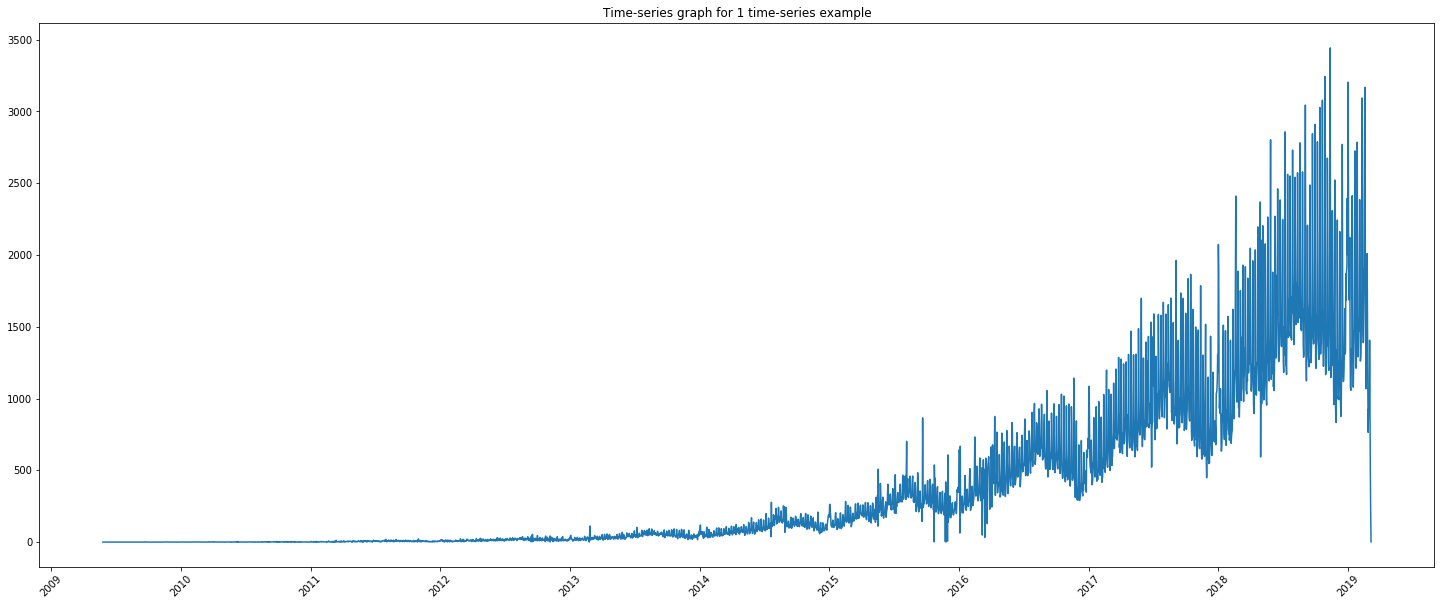

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  #я хз что это но надо для нормальной оси дат

f,(ax, ax1) = plt.subplots(1,1, figsize=(25,10))
ax.plot(df_example['ts'])
ax.set_title('Time-series graph for 1 time-series example')
ax.tick_params(axis = 'x', rotation = 45)
plt.show()

## Проверка стационарности
Чтобы AR, MA, ARIMA, SARIMA работали должны выполняться определенные предпосылки, важнейшая из которых - __стационарность__. Простыми словами, это значит, что закономерности, наблюдаемые в данных не должны меняться со временем, т.е.:
 - неизменная дисперсия;
 - неизменное среднее;
 - автоковариация не зависит от времени (т.е. автоковариация серии Yt такая же, как у Yt-k)
 
В реальности такую конечно фиг найдешь, поэтому, как правило, к данным применяются обратимые трансформации (например, логарифмирование или взятие разницы).

Также, для оценки стационарности процесса можно использовать формальные тесты, например dickey-fuller или KPSS. Кстати, у этих тестов разные нулевые гипотезы (у дики фуллера, что серия не стационарна, а у КПСС - наоборот).

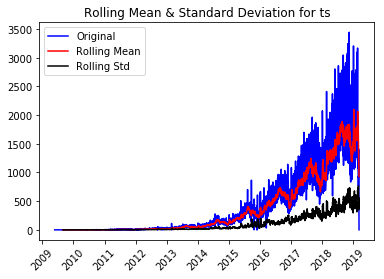

Test Statistic                                                         -0.986665
p-value                                                                 0.758097
# Lags Used                                                                   29
Number of Observations Used                                                 3214
Critical levels                {'1%': -3.4323862571453185, '5%': -2.862439695...
dtype: object


1

In [5]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df,ts,lag):
    """A simple function to test stationarity of a times series using Dickey-Fuller and plot it with rolling mean and variance"""
    rolmean =  df[ts].rolling(window=12, center=False).mean()
    rolstd = df[ts].rolling(window=12, center=False).std()
    
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    df_test_aic = adfuller(df[ts],autolag = lag)
    dfoutput_aic = pd.Series(df_test_aic[0:5], 
                index = ['Test Statistic',
                        'p-value',
                        '# Lags Used',
                        'Number of Observations Used',
                        'Critical levels'])
    print(dfoutput_aic)
    return 1
test_stationarity(df_example, 'ts', 'AIC')

## Трансформации данных
Как мы видим, наши данные не стационарны в самом худшем варианте - виден тренд и изменение волатильности со временем. При такой картинке, не удивительно, что они не проходят тест дики-фуллера. 
 Чтобы сделать из не стационарных данных стационарные применяют различные трансформации (обратимые, чтобы можно было из прогноза для трансформированных данных получить прогноз для изначальных данных). Самые популярные трансформации - логарифмирование, скользящее среднее (недельное, например) и взятие разницы (это когда мы из Yt вычитаем Yt-1 и получаем не серию значений переменной во времени, а серию __изменений__ ее значений).

Отдельного упоминания заслуживает такая трансформация как взвешенное экспоненциальное сглаживание (EWMA). Математически его суть в следующем:
предполагается, что текущее значение зависит от всех предыдущих, но более поздним значениям присваивается более высокий вес. Почему экспоненциальное? Потому что, еcли вес самого свежего наблюдения равен $\alpha$, то вес предыдущего будет равен $1-\alpha^2$ и т.д.
В деталях о том, как это устроено в pandas можно глянуть [тут](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html)

In [6]:
def plot_transformed_data(df,ts,ts_transformed):
    f,ax = plt.subplots(1,1)
    ax.plot(df[ts])
    ax.plot(df[ts_transformed], color='red')
    ax.set_title(f"Transformed ({ts_transformed}) vs non-transformed ({ts}) data")
    ax.tick_params(axis='x', labelrotation = 45)
    
    plt.show()
    plt.close()
    
    return None
    

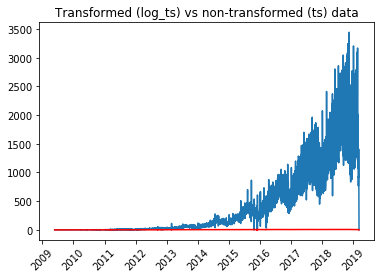

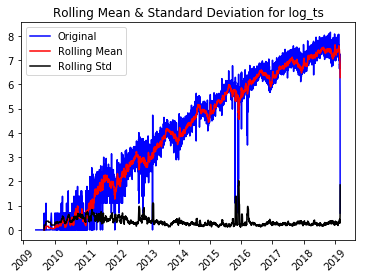

Test Statistic                                                          -2.01201
p-value                                                                 0.281333
# Lags Used                                                                   22
Number of Observations Used                                                 3221
Critical levels                {'1%': -3.4323818283394387, '5%': -2.862437739...
dtype: object


1

In [7]:
df_example['log_ts'] = df_example['ts'].apply(np.log) #не забываем, что логарифм нуля = минус бесонечность и это сломает нам все нахрен
#df_look = df_example[df_example['log_ts']==-np.inf]
plot_transformed_data(df_example, 'ts', 'log_ts')
test_stationarity(df_example,'log_ts','AIC')

Как мы видим, логарифм помог +- избавиться от увеличения дисперсии сделав ее практически постоянной, но никак не помог нам с трендом, который по-прежнему сохраняется. Поэтому ничего удивительного, что дики-фуллер не пройден.

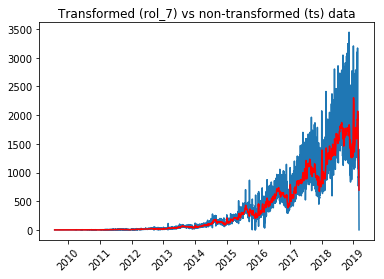

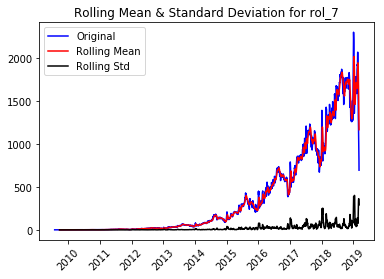

Test Statistic                                                          -0.66824
p-value                                                                 0.854806
# Lags Used                                                                   29
Number of Observations Used                                                 3208
Critical levels                {'1%': -3.4323900686602644, '5%': -2.862441378...
dtype: object


1

In [8]:
df_example['rol_7'] = df_example['ts'].rolling(window = 7, center=False).mean()
df_example.dropna(inplace=True) #Скидываем нули для первых шести дней, которые не дадут дики-фуллера посчитать
plot_transformed_data(df_example, 'ts', 'rol_7')
test_stationarity(df_example,'rol_7','AIC')

Как мы видим, скользящее среднее за неделю вообще нам не помогло - тренд остался на месте, дисперсия хоть и снизилась, н

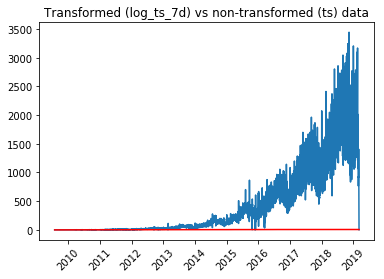

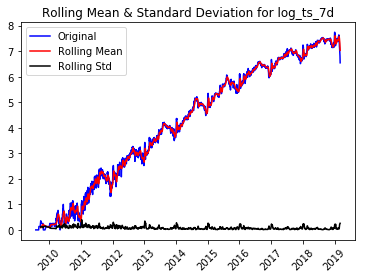

Test Statistic                                                          -2.18129
p-value                                                                 0.213107
# Lags Used                                                                   28
Number of Observations Used                                                 3209
Critical levels                {'1%': -3.4323894324171813, '5%': -2.862441097...
dtype: object


1

In [9]:
df_example['log_ts_7d'] = df_example['rol_7'].apply(np.log) #не забываем, что логарифм нуля = минус бесонечность и это сломает нам все нахрен
#df_look = df_example[df_example['log_ts']==-np.inf]
plot_transformed_data(df_example, 'ts', 'log_ts_7d')
test_stationarity(df_example,'log_ts_7d','AIC')

Логарифмирование недельного роллинга ожидаемо снизило дисперсию, но практически никак не помогло с трендом.

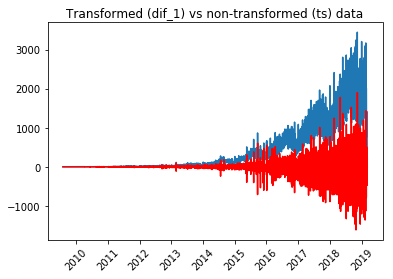

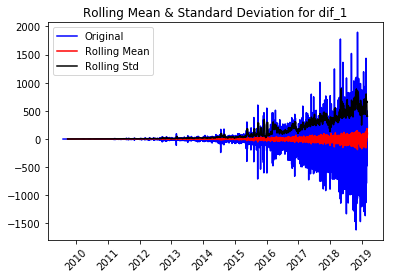

Test Statistic                                                          -10.4881
p-value                                                              1.16597e-18
# Lags Used                                                                   29
Number of Observations Used                                                 3207
Critical levels                {'1%': -3.4323907053004503, '5%': -2.862441660...
dtype: object


1

In [10]:
df_example['dif_1'] = df_example['ts'].shift(periods=1)
df_example = df_example.dropna()
df_example['dif_1'] = df_example['dif_1']-df_example['ts']
plot_transformed_data(df_example, 'ts', 'dif_1')
test_stationarity(df_example,'dif_1','AIC')

Как мы видим, тут ситуация обратная - мы практически убрали тренд, сделав среднюю постоянной, в то же время видно, что стандартное отклонение по-прежнему имеет тенденцию к росту. В то же время этого хватило чтобы пройти дики-фуллера. Собственно взятие разницы - центральная часть метода ARIMA, где I=Integrated = разница. Нам в общем и целом хватило разницы первого порядка, но в теории можно опускаться и глубже. В то же время на практике редко идут ниже двух порядков, т.к. моделировать изменения изменения изменения - это странновато.

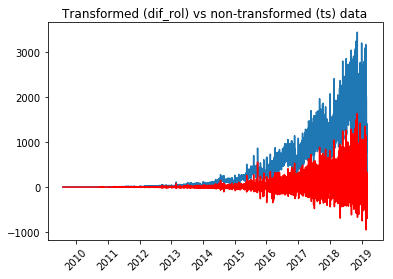

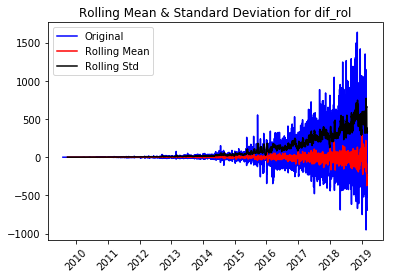

Test Statistic                                                          -10.4017
p-value                                                              1.90257e-18
# Lags Used                                                                   29
Number of Observations Used                                                 3207
Critical levels                {'1%': -3.4323907053004503, '5%': -2.862441660...
dtype: object


1

In [11]:
df_example['dif_rol'] = df_example['ts']-df_example['rol_7']
plot_transformed_data(df_example, 'ts', 'dif_rol')
test_stationarity(df_example,'dif_rol','AIC')

Отклонение от скользящего среднего тоже далдо неплохой результат и прошло дики-фуллера.

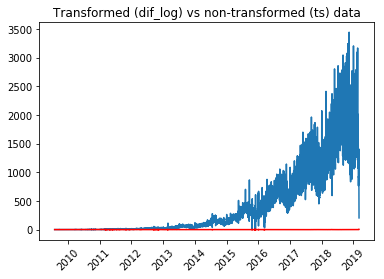

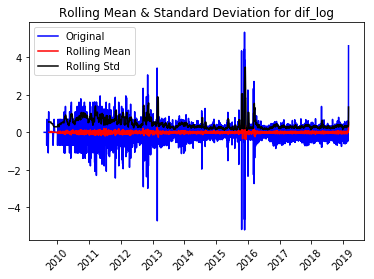

Test Statistic                                                          -11.6644
p-value                                                              1.89934e-21
# Lags Used                                                                   29
Number of Observations Used                                                 3206
Critical levels                {'1%': -3.4323913423381103, '5%': -2.862441941...
dtype: object


1

In [12]:
df_example['dif_log'] = df_example['log_ts'].shift(periods=-1)
df_example.dropna(inplace=True)
df_example['dif_log'] = df_example['log_ts'] - df_example['dif_log']
plot_transformed_data(df_example, 'ts', 'dif_log')
test_stationarity(df_example,'dif_log','AIC')

Тут результат реально уже напоминает белый шум, к чему мы и стремимся, дики-фуллер здесь наилучший, из графиков видно, что средняя почти постоянная, как и $\sigma$ за исключением отдельных скачков.

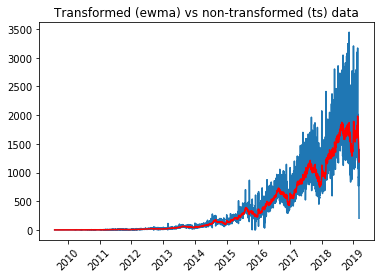

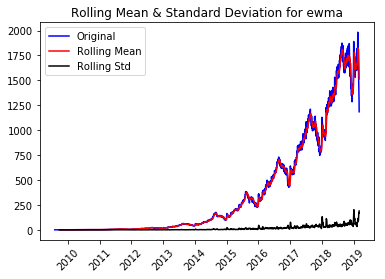

Test Statistic                                                         -0.271804
p-value                                                                 0.929404
# Lags Used                                                                   29
Number of Observations Used                                                 3206
Critical levels                {'1%': -3.4323913423381103, '5%': -2.862441941...
dtype: object


1

In [13]:
df_example['ewma'] = df_example['ts'].ewm(halflife=7).mean()
df_example.dropna(inplace=True)
plot_transformed_data(df_example, 'ts', 'ewma')
test_stationarity(df_example,'ewma','AIC')

EWMA ожидаемо не справляется с устранением тренда, но практически справляется с дисперсией.

## Модель ARIMA и оценка ее параметров.
Для начала воспользуемся обычной аримой. У нее есть три параметра - p,d,q. p отвечает за авторегрессионный компонент, d - за дифференцирование (в том смысле, что берется разница текущего значения с предыдущим, что мы и делали ранее). Этот параметр нужен для обеспечения стационарности серии. q, как несложно догадаться отвечает за скользящее среднее.

Для оценки параметров и выбора их оптимальной комбинации крайне полезно посмотреть на графики автокорелляционной функции (acf) и частной автокорреляционной функции (pacf). ACF показывает __суммарную корреляцию__ $Y_t$ и $Y_t-_k$, т.е. насколько текущее значение коррелирует со всеми предыдущими. PACF же показывает корреляцию непосредственно между $Y_t$ и $Y_t-_k$.

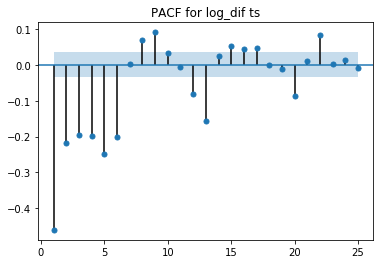

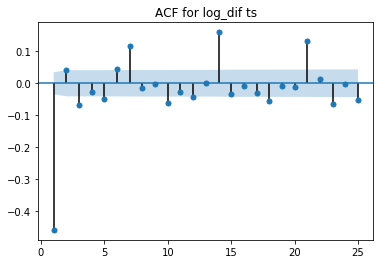

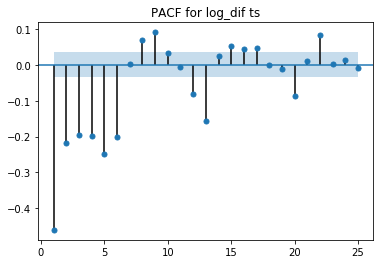

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(x=df_example['dif_log'], lags=25, alpha = 0.05, title='ACF for log_dif ts', zero=False)
plot_pacf(x=df_example['dif_log'], lags=25, alpha = 0.05, title='PACF for log_dif ts', zero=False)
#хз почему он задваивает один график

Хорошее rule-of-thumb: ACF помогает нам определить параметр p, то бишь авторегрессионный (что логично, т.к. он показывает накопленную автокорелляцию), а PACF помогает определить параметр q. Исходя из наших графиков имеет смысл попробовать простой вариант, где p=q=1, а дальше уже эксперементировать с p=7 и q⩽6.

F:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                dif_log   No. Observations:                 3236
Model:                     ARMA(1, 1)   Log Likelihood               -1798.971
Method:                       css-mle   S.D. of innovations              0.422
Date:                Sun, 28 Apr 2019   AIC                           3605.943
Time:                        18:13:18   BIC                           3630.271
Sample:                             0   HQIC                          3614.660
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0020      0.001     -3.371      0.001      -0.003      -0.001
ar.L1.dif_log     0.0638      0.020      3.236      0.001       0.025       0.102
ma.L1.dif_log    -0.9259      0.008   -1

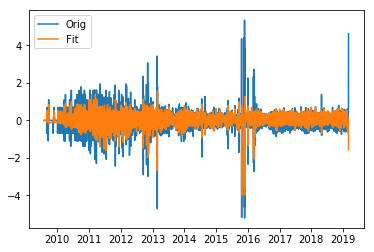

In [15]:
from statsmodels.tsa.arima_model import ARIMA
def run_arima(df,ts,p,d,q):
    model = ARIMA(df[ts], order=(p,d,q))
    result = model.fit(transparams=False, disp=False)
    print(result.summary(0.05))
    plt.plot(df[ts], label="Orig") #график с оригинальными цифрами
    plt.plot(result.fittedvalues, label='Fit') #график с предсказаннами значениями
    plt.legend(loc='best')
    return result
run_arima(df_example, 'dif_log', 1,0,1)

Теперь проверим, нормально ли мы выбрали модель, основываясь только на графиках ACF и PACF. Для этого воспользуемся специальной библиотекой, которая подбирает оптимальные параметры для аримы. Минимизировать будем AIC - (Akaikke information criterion). Этот критерий поощряет модели за goodness-of-fit, и наказывает за кол-во параметров. Иными словами, добавление нового параметра в рамках этого критерия оправдано только если он существенно улучшает кач-во модели.

In [16]:
from pmdarima.arima import auto_arima
params = auto_arima(df_example['dif_log'], start_p=1, start_q=1, d=0, max_p=8, max_q=7, seasonal=False,
                   trace=True, error_action='ignore', supress_warnings=True)
params.summary()

Fit ARIMA: order=(1, 0, 1); AIC=3605.943, BIC=3630.271, Fit time=0.576 seconds
Fit ARIMA: order=(0, 0, 0); AIC=5307.491, BIC=5319.655, Fit time=0.002 seconds
Fit ARIMA: order=(1, 0, 0); AIC=4519.138, BIC=4537.385, Fit time=0.095 seconds
Fit ARIMA: order=(0, 0, 1); AIC=3614.411, BIC=3632.657, Fit time=0.241 seconds
Fit ARIMA: order=(2, 0, 1); AIC=3607.766, BIC=3638.176, Fit time=0.783 seconds
Fit ARIMA: order=(1, 0, 2); AIC=3607.908, BIC=3638.319, Fit time=0.837 seconds
Fit ARIMA: order=(2, 0, 2); AIC=3593.421, BIC=3629.913, Fit time=0.724 seconds
Fit ARIMA: order=(3, 0, 2); AIC=3531.070, BIC=3573.644, Fit time=0.979 seconds
Fit ARIMA: order=(3, 0, 1); AIC=3564.375, BIC=3600.868, Fit time=0.716 seconds
Fit ARIMA: order=(3, 0, 3); AIC=3184.682, BIC=3233.339, Fit time=2.832 seconds
Fit ARIMA: order=(4, 0, 4); AIC=3187.868, BIC=3248.689, Fit time=4.801 seconds
Fit ARIMA: order=(2, 0, 3); AIC=3200.040, BIC=3242.615, Fit time=2.631 seconds
Fit ARIMA: order=(4, 0, 3); AIC=3186.247, BIC=3240.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 3236
Model:                     ARMA(3, 3)   Log Likelihood               -1584.341
Method:                       css-mle   S.D. of innovations              0.395
Date:                Sun, 28 Apr 2019   AIC                           3184.682
Time:                        18:13:52   BIC                           3233.339
Sample:                             0   HQIC                          3202.117
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -2.431      0.015      -0.003      -0.000
ar.L1.y        1.1449      0.024     48.263      0.000       1.098       1.191
ar.L2.y       -0.8762      0.029    -30.111      0.000      -0.933      -0.819
ar.L3.y       -0.0951      0.023     -4.162      0.000      -0.140      -0.050
ma.L1.y       -2.0932      0.017   -124.734      0.000      -2.126      -2.060
ma.L2.y        2.0145      0.026     78.676      0.000       1.964       2.065
ma.L3.y       -0.8296      0.016    -50.701      0.000      -0.862      -0.797
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6235           -0.7852j            1.0026           -0.1432
AR.2            0.6235           +0.7852j            1.0026            0.1432
AR.3          -10.4629           -0.0000j           10.4629           -0.5000
MA.1            0.6424           -0.8009j            1.0266           -0.1424
MA.2            0.6424           +0.8009j            1.0266            0.1424
MA.3            1.1437           -0.0000j            1.1437           -0.0000
-----------------------------------------------------------------------------
"""

## Facebook Prophet
Facebook prophet - это пакет для прогнозирования временных рядов,созданный ВНЕЗАПНО фейсбуком. Позволяет генерить прогнозвы нестационарных временных рядов, автоматически вытаскивая тренд и сезонность. Кроме того, хоть тут это и не демонстрируется, позволяет выделять также эффект от выходных, праздников и т.п. Русские праздники даже есть в комплекте. Кроме того, можно добавлять внешний регрессор и валидировать модель. Лучше всего работает с дневными данными, однако может работать и с месячными, главное соблюдать гранулярность (т.е. для месячного обучения давать месячный прогноз, а не пытаться дневной родить).

Так же он автоматом посчитает метрики ошибок - MSE (Mean squared error), RMSE (Root mean squared error), MAE(Mean absolute error), MAPE(Mean absolute percentage error). Про MAPE стоит помнить, что эта метрика наказывает перепрогноз сильнее, чем недопрогноз, что при бездумном использовании приводит к недоперформящим моделям. Четко про метрики расписано [тут](http://forecasting.svetunkov.ru/en/2017/07/29/naughty-apes-and-the-quest-for-the-holy-grail/) и [тут](https://stats.stackexchange.com/questions/299712/what-are-the-shortcomings-of-the-mean-absolute-percentage-error-mape) 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2012-10-03 00:00:00 and 2018-03-06 00:00:00


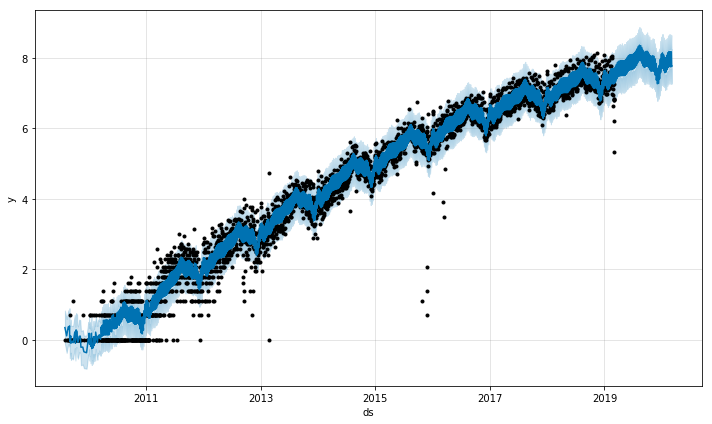

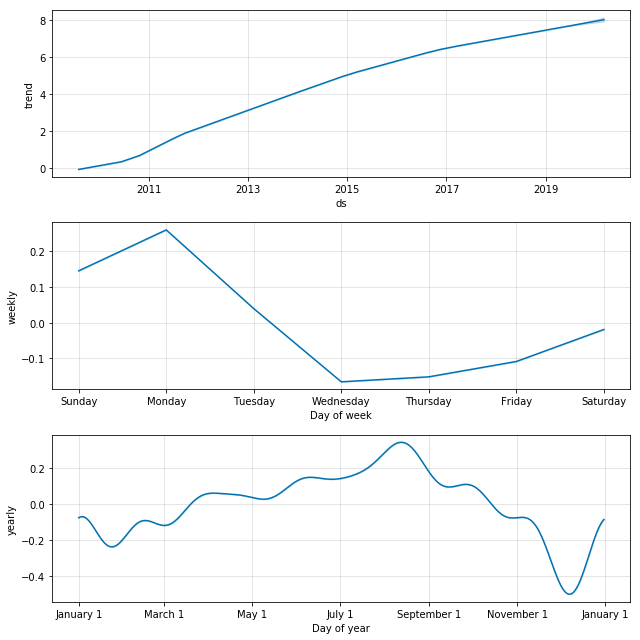

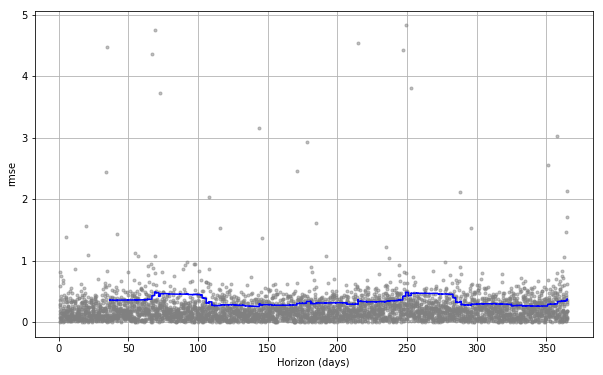

In [26]:
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation
fbdf = df_example['log_ts']
fbdf = fbdf.reset_index(level=0)
fbdf.columns = ['ds','y']
def prophet_forecast(df, initial, period, horizon):
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    model.plot(forecast)
    model.plot_components(forecast)
    df_cv = cross_validation(model,initial=initial,period=period,horizon=horizon)
    df_met = performance_metrics(df_cv)
    plot_cross_validation_metric(df_cv, metric='rmse')
    return forecast, df_cv, df_met
res = prophet_forecast(fbdf, initial = '1095 days', period='180 days', horizon='365 days')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 12 forecasts with cutoffs between 2012-10-03 00:00:00 and 2018-03-06 00:00:00


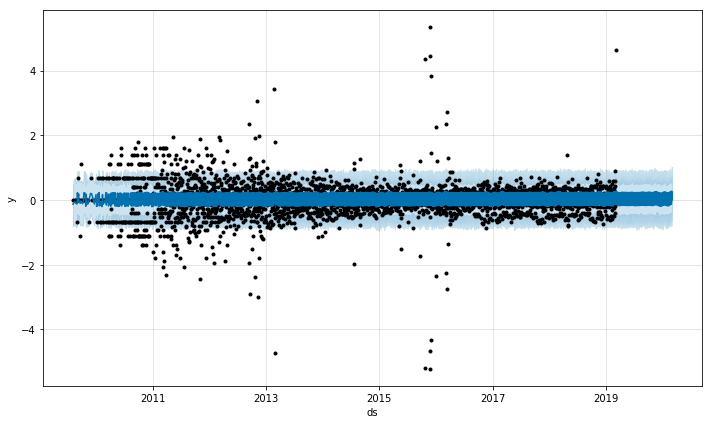

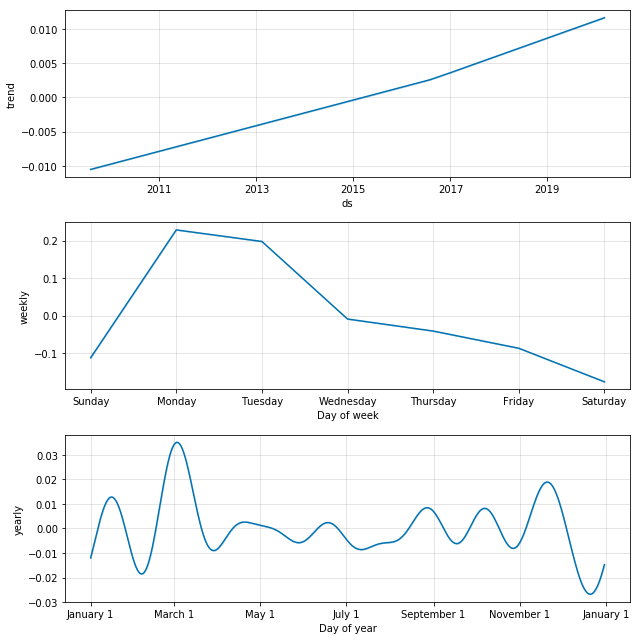

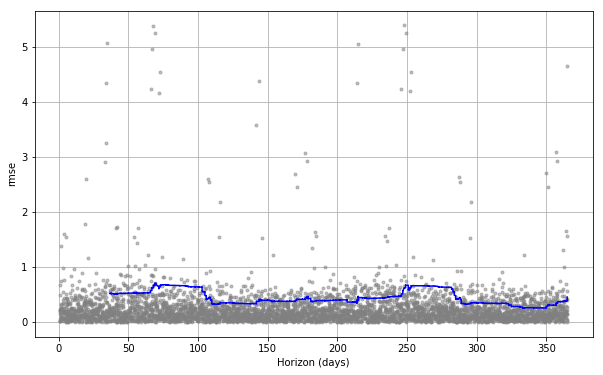

In [28]:
fbdf1 = df_example['dif_log']
fbdf1 = fbdf1.reset_index(level=0)
fbdf1.columns = ['ds','y']
res1 = prophet_forecast(fbdf1, initial = '1095 days', period='180 days', horizon='365 days')
